## ライブラリの読み込み

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

print("ライブラリ読み込み完了")

ライブラリ読み込み完了


## デバイスの設定

In [2]:
if torch.cuda.is_available():           # GPUが使えたら
    device ="cuda:0"
elif torch.backends.mps.is_available(): # Apple siliconが使えたら
    device = "mps"
else:
    device = "cpu"

print(f"使用するデバイス:{device}")

使用するデバイス:cuda:0


# VAEモデルのエンコーダ

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=20):
        super(Encoder, self).__init__()

        # 畳み込み層
        self.encoder = nn.Sequential(
            # 第1畳み込み層 : 1チャネル→32チャネル
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1), # -> 32x14x14
            nn.ReLU(),

            # 第2畳み込み層 : 32チャネル→64チャネル
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> 64x7x7
            nn.ReLU(),
        )

        # 全結合層への変換 : 畳み込み層の出力(64×7×7=3136)を400次元に圧縮
        self.fc1 = nn.Linear(64*7*7, 400)    # この層で特徴量の次元を大きく削減

        # 潜在変数の分布パラメータを出力する層
        self.fc_mu = nn.Linear(400, latent_dim)   # 平均 : 潜在空間での位置
        self.fc_var = nn.Linear(400, latent_dim)  # 分散の対数 : 潜在空間での不確実性

    def forward(self, x):
        # 畳み込み層による特徴抽出
        # バッチサイズ × 1 × 28 × 28 --> バッチサイズ × 64 × 7 × 7
        x = self.encoder(x)

        # 特徴マップを1次元に変換
        # バッチサイズ × 64 × 7 × 7 -> バッチサイズ × (64 × 7 × 7)
        x = x.view(x.size(0), -1)

        # 全結合層
        # バッチサイズ × (64 × 7 × 7) -> バッチサイズ × 400
        x = F.relu(self.fc1(x))

        # 潜在変数の分布パラメータを計算
        # バッチサイズ × 400 -> バッチサイズ × latent_dim
        mu = self.fc_mu(x)          # 平均を計算
        log_var = self.fc_var(x)    # 分散の対数を計算

        return mu, log_var

## VAEモデルのデコーダ

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=20):
        super(Decoder, self).__init__()

        # 入力層
        self.decoder_input = nn.Linear(latent_dim, 400)  # latent_dim -> 400
        self.decoder_fc = nn.Linear(400, 64*7*7)    # 400 -> 64(channel)×7×7

        # 転置畳み込み層
        self.decoder = nn.Sequential(
            # 第1転置畳み込み層 : 64チャネル→32チャネル
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> 32x14x14
            nn.ReLU(),

            # 第2転置畳み込み層 : 32チャネル→1チャネル
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> 1x28x28
            nn.Sigmoid()    # 出力値を[0, 1]に正規化
        )

    def forward(self, z):
        # 第1全結合層
        # バッチサイズ × latent_dim -> バッチサイズ × 400
        x = F.relu(self.decoder_input(z))

        # 第2全結合層
        # バッチサイズ × 400 -> バッチサイズ × (64 × 7 × 7)
        x = F.relu(self.decoder_fc(x))

        # テンソルの形状を変更
        # バッチサイズ × (64 × 7 × 7) -> バッチサイズ × 64 × 7 × 7
        x = x.view(x.size(0), 64, 7, 7)

        # 転置畳み込み層 : 画像再構成
        # バッチサイズ × 64 × 7 × 7 --> バッチサイズ × 1 × 28 × 28
        x = self.decoder(x)

        return x


## VAEモデル

エンコーダとデコーダをつなげる

学習時(self.training=True)とテスト時で異なる挙動をする
- 学習時: 分散を考慮した確率的なサンプリング
- テスト時: 平均値のみを使用した決定論的な出力

VAEの処理フロー
1. エンコード: 入力→潜在分布のパラメータ(μ, σ²)
2. サンプリング: 潜在分布からのサンプリング
3. デコード: 潜在変数→再構成画像

In [5]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)  # エンコーダ
        self.decoder = Decoder(latent_dim)  # デコーダ

    def reparametarize(self, mu, log_var):
        """平均と分散の対数を使って、潜在変数をサンプリングする"""
        if self.training:
            # 標準偏差の計算
            std = torch.exp(0.5 * log_var)

            # 標準正規分布からのランダムサンプリング
            eps = torch.randn_like(std)

            # 潜在変数の計算
            z = mu + std * eps

            return z
        else:
            return mu

    def forward(self, x):
        """VAEの順伝播"""
        # 1. エンコーダ
        mu, log_var = self.encoder(x)

        # 2. サンプリング
        z = self.reparametarize(mu, log_var)

        # 3. デコーダ
        recon_x = self.decoder(z)

        return recon_x, mu, log_var


# 再現性のための乱数シードを設定
torch.manual_seed(42)   # PyTorchの乱数シードを固定
np.random.seed(42)      # NumPyの乱数シードを固定（必要な場合）

# VAEモデルの初期化とGPU/CPUへの転送
latent_dim = 20     # 潜在空間の次元数
model = VAE(latent_dim).to(device)

print("モデル完成")

モデル完成


## モデル構造の表示

**出力の見方**
1. Layer（層の種類）
  - Conv2d: 2次元畳み込み層
  - ConvTranspose2d: 2次元転置畳み込み層
  - Linear: 全結合層
  - ReLU: 活性化関数

2. Output Shape（出力の形状）
  - [バッチサイズ, チャネル数, 高さ, 幅]
  - バッチサイズは-1で表示（可変）

3. Param #（パラメータ数）
  - その層の学習可能なパラメータの総数
  - カーネル、バイアスなどの合計


**主なポイント**
1. パラメータ数の計算方法
  - Conv2d: (入力チャネル×カーネルサイズ×カーネルサイズ×出力チャネル) + 出力チャネル
  - Linear: 入力サイズ×出力サイズ + 出力サイズ

2. ReLUやSigmoidはパラメータを持たない
  - Param # = 0

3. モデルの複雑さの指標
  - Total paramsが多いほど複雑
  - 学習時間やメモリ使用量に影響

In [6]:
from torchsummary import summary

if device == "mps":  # Apple Siliconの場合
    summary(model.to("cpu"), (1, 28, 28))  # 入力サイズ: (チャネル数, 高さ, 幅) = (1, 28, 28)
    model.to(device)
else:               # GPU/CPUの場合
    summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
              ReLU-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 400]       1,254,800
            Linear-6                   [-1, 20]           8,020
            Linear-7                   [-1, 20]           8,020
           Encoder-8       [[-1, 20], [-1, 20]]               0
            Linear-9                  [-1, 400]           8,400
           Linear-10                 [-1, 3136]       1,257,536
  ConvTranspose2d-11           [-1, 32, 14, 14]          18,464
             ReLU-12           [-1, 32, 14, 14]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]             289
          Sigmoid-14            [-1, 1,

## MNISTデータセットの準備

In [7]:
#データの前処理とローダーの設定
transform = transforms.Compose([
    transforms.ToTensor() # PILイメージをテンソルに変換し、[0,1]に正規化
])

# MNISTデータセットのダウンロードと準備
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=True
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.63MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 136kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.29MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.51MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 損失関数の定義とオプティマイザーの設定

損失関数は2つの項からなる
1. 再構成誤差 (BCE): 入力と再構成画像の類似度
2. KLダイバージェンス (KLD): 潜在変数の分布を標準正規分布に近づける正則化項

In [8]:
# 損失関数
def loss_function(recon_x, x, mu, log_var):
    """VAEの損失関数"""
    # 1.再構成誤差 (BCE)
    BCE = F.binary_cross_entropy(
        recon_x.view(-1, 784),  # 1次元に変換([1, 28, 28]->[1*28*28])
        x.view(-1, 784),        # 1次元に変換([1, 28, 28]->[1*28*28])
        reduction='sum')

    # 2.KLダイバージェンス
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # 損失 = BCE + KLD
    total_loss = BCE + KLD

    return total_loss

# オプティマイザー（学習率lr = 0.0001 = 1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 学習関数の定義

学習の流れ

        1. バッチごとにデータを取得
        2. モデルで再構成を行う
        3. 損失を計算
        4. 逆伝播で勾配を計算
        5. オプティマイザでパラメータを更新

In [9]:
def train(epoch):
    model.train()

    train_loss = 0  # エポック全体の損失
    n_samples = 0   # サンプル数

    # バッチ処理
    for data, _ in train_loader:
        data = data.to(device)  # データをデバイスに転送

        # 順伝播計算
        # - recon_batch: 再構成された画像
        # - mu: 潜在変数の平均
        # - log_var: 潜在変数の分散の対数
        recon_batch, mu, log_var = model(data)

        # 損失の計算
        loss = loss_function(recon_batch, data, mu, log_var)

        optimizer.zero_grad()   # 勾配初期化
        loss.backward()         # 勾配の計算
        optimizer.step()        # パラメータの更新

        train_loss += loss.item()   # 損失を累積
        n_samples += data.size(0)   # バッチサイズを加算

    # エポック終了時に平均損失を計算
    avg_loss = train_loss / n_samples

    return avg_loss

# 画像表示関数

In [10]:
def show_image(image, title=""):
    plt.imshow(image.reshape(28, 28), cmap="gray")  # 28x28にリシェイプして表示
    plt.title(title)
    plt.axis("off")     # 軸を非表示

## グリッドレイアウトの行数と列数を計算する関数

In [11]:
def calc_row_and_col(n_images):
    row = int(np.sqrt(n_images))    # n_imagesの平方根（整数部のみ）
    col = n_images // row           # 行数で割った商

    # 必要に応じてグリッドサイズを調整
    # 例：n_images=10の場合、3x3では足りないので4x3に調整
    if row * col < n_images:
        # より効率的なレイアウトを選択
        if (row + 1) * col <= (row * (col + 1)):
            row += 1 # 行を増やす
        else:
            col += 1 # 列を増やす

    return row, col

## 画像の生成と表示

1. 潜在空間からランダムサンプリング
2. デコーダで画像生成
3. グリッド状に配置して表示

In [12]:
def generate_and_show_images(n_images=16):
    """VAEで画像を生成し、グリッド状に表示する関数"""
    # モデルを評価モードに設定
    model.eval()

    # 勾配計算を無効化（メモリ効率化のため）
    with torch.no_grad():
        # 1. 潜在空間からのサンプリング
        # 標準正規分布N(0,1)から生成
        z = torch.randn(n_images, latent_dim).to(device)

        # 2. 画像生成
        sample = model.decoder(z)

        # 3.1 表示設定
        plt.figure(figsize=(5, 5))

        # 3.2 グリッドレイアウトの行数と列数を計算
        row, col = calc_row_and_col(n_images)

        # 3.3 画像をグリッド状に表示
        for i in range(n_images):
            plt.subplot(row, col, i + 1) # サブプロット作成
            show_image(sample[i].cpu()) # GPU->CPU変換して表示

        # 3.4 レイアウトの調整と表示
        plt.tight_layout()
        plt.show()

## 学習前のモデルで画像生成

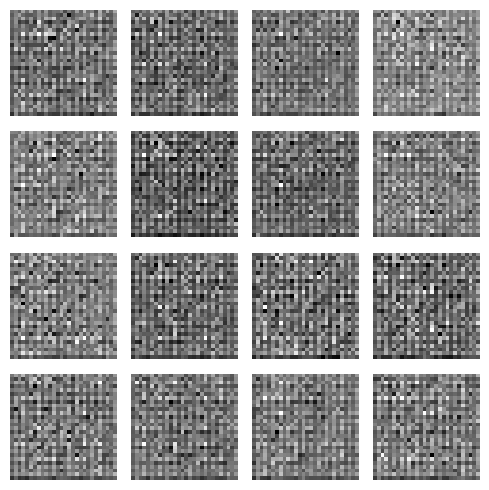

In [13]:
generate_and_show_images(16)

## 学習曲線をプロットする関数

In [14]:
def plot_training_curve(losses):
    """学習曲線（損失の推移）をプロットする関数"""
    # プロット領域の作成（横長のサイズ）
    plt.figure(figsize=(10, 5))

    # 損失値のプロット
    plt.plot(losses, label='Training Loss')

    plt.xlabel('Epoch')         # x軸の設定
    plt.ylabel('Average Loss')  # y軸の設定
    plt.title('Training Loss')  # タイトルの設定
    plt.legend()                # 凡例の表示
    plt.grid(True)              # グリッド線の表示
    plt.show()                  # プロットの表示

## 学習の実行

Epoch[ 1/10] Loss:172.998446 time:9.86sec

=== Generating images at epoch 1 ===


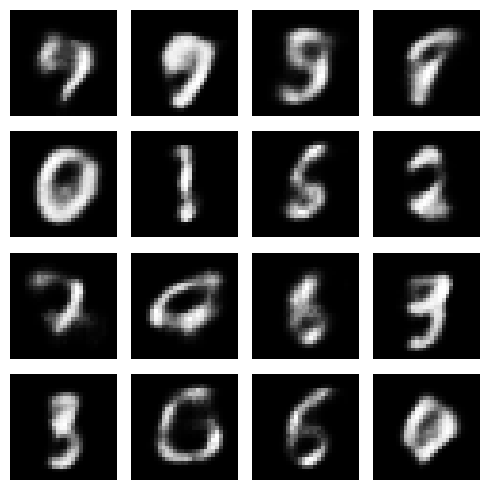


Epoch[ 2/10] Loss:116.506505 time:9.01sec
Epoch[ 3/10] Loss:108.498845 time:8.67sec
Epoch[ 4/10] Loss:105.696475 time:9.16sec

=== Generating images at epoch 4 ===


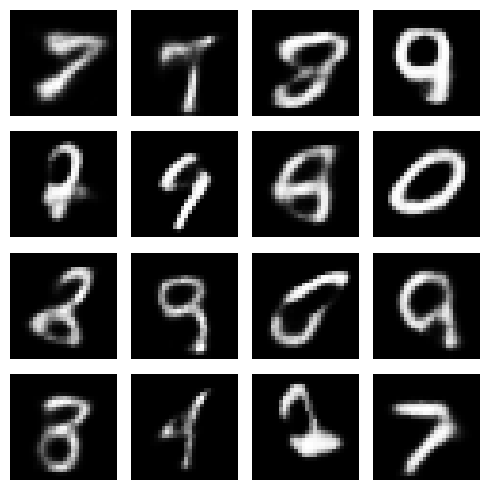


Epoch[ 5/10] Loss:104.038310 time:9.19sec
Epoch[ 6/10] Loss:102.888725 time:8.96sec
Epoch[ 7/10] Loss:101.981240 time:8.62sec

=== Generating images at epoch 7 ===


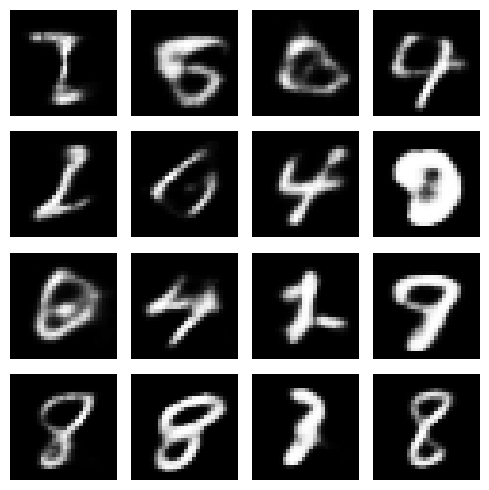


Epoch[ 8/10] Loss:101.232987 time:10.13sec
Epoch[ 9/10] Loss:100.698430 time:9.18sec
Epoch[10/10] Loss:100.226185 time:9.09sec

=== Generating images at epoch 10 ===


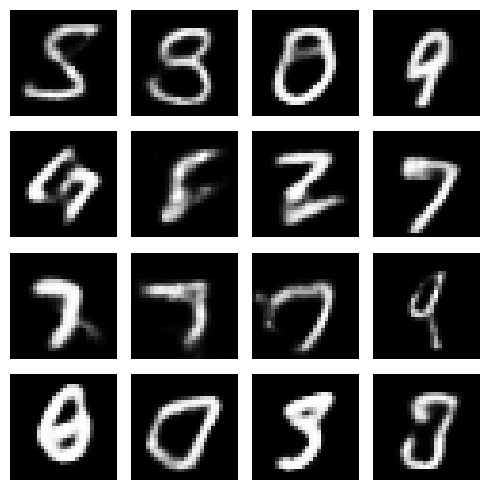

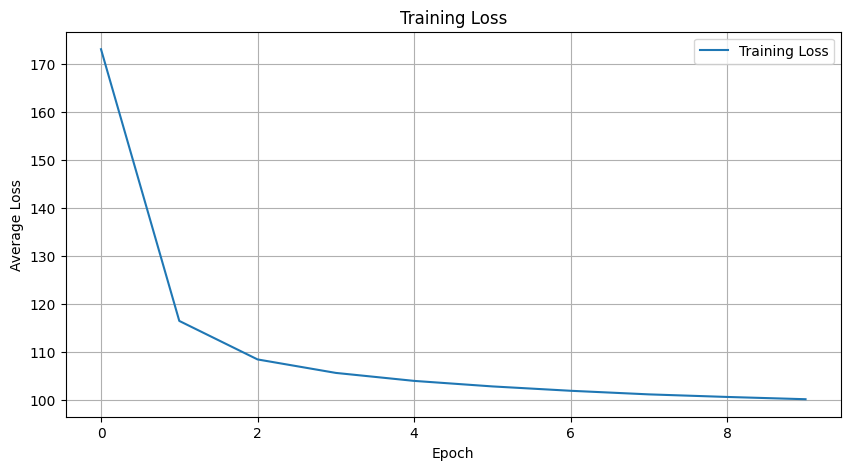

In [15]:
import time
# 学習パラメータの設定
num_epochs = 10 # 学習エポック数
training_losses = [] # 損失値を記録するリスト

# メインの学習ループ
for epoch in range(num_epochs):
    start_time = time.time() # 開始時間を記録
    avg_loss = train(epoch) # 1エポック分の学習を実行
    end_time = time.time() # 終了時間を記録
    # 統計情報の記録と表示
    training_losses.append(avg_loss) # 損失値を記録
    training_time = end_time - start_time # エポックの所要時間
    # 進捗状況の表示
    print(f"Epoch[{epoch+1:2d}/{num_epochs}] "
          f"Loss:{avg_loss:.6f} "
          f"time:{training_time:.2f}sec")
    # 定期的に生成画像を確認
    if epoch % 3 == 0: # 3エポックごと
        print(f"\n=== Generating images at epoch {epoch+1} ===")
        generate_and_show_images()
        print("=====================================\n")

plot_training_curve(training_losses) # 学習曲線のプロット

## 学習済みモデルで画像の生成・表示

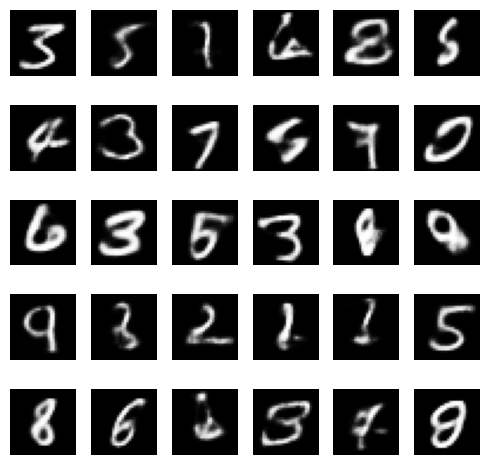

In [16]:
generate_and_show_images(30)

## おまけ

潜在ベクトルの数値を変えれば数字が変わる

概ね，それぞれ-3.0～3.0

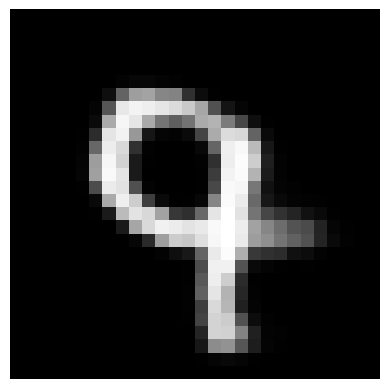

In [40]:
# 潜在ベクトル(20次元)
z = torch.Tensor([
    [0.0, 0.0, 0.0, -3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
     0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
]).to(device)

# 画像生成
sample = model.decoder(z)

# 画像表示
show_image(sample[0].cpu().detach())